In [38]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator


device = 'cuda:3'


truncate_circle = False

Load the Modes and the derivatives

In [39]:
microlens = 20 #20x20
size = microlens

n_zernike_rows = 4
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

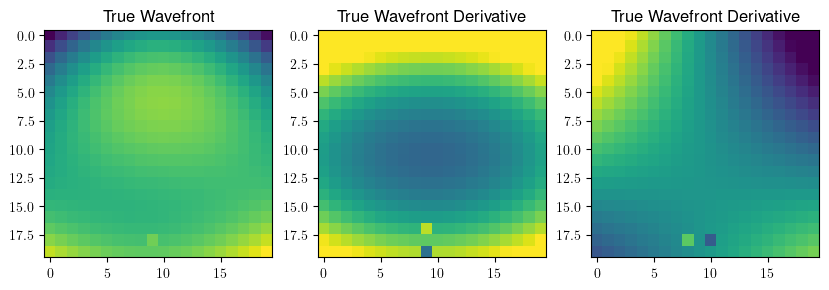

In [40]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2]

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(3,n_zernike)
np.random.shuffle(elements)
elements = elements[:3]
zer_coeffs = torch.randn(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs
# mode_coeffs[n_zernike] = 1 #vortex

mode_coeffs[380] = 1

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1); ax[2].set_title('True Wavefront Derivative')

## From here I show once we have gradients


In [41]:
sampled_gradient = wavefront_deriv.clone()
sampled_gradient[:,10,10] = np.nan

sampled_gradient+=torch.randn_like(sampled_gradient)*0.01 * torch.max(torch.nan_to_num(sampled_gradient))

evaller = ModalEvaluator(size=(size,size), n_zernike_rows=n_zernike_rows, zern_transform=False, device=device)

In [42]:
coeffs, history = evaller.fit(sampled_gradient, epochs=4000, lr=2e-3, l1_reg=5e-4)

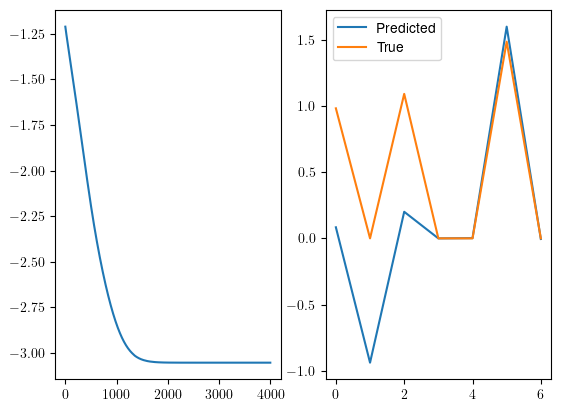

In [43]:
fig,ax = plt.subplots(1,2)
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][0,3:n_zernike].detach().cpu()/2)
ax[1].plot(mode_coeffs[3:n_zernike,0,0])
ax[1].legend(['Predicted','True'])

In [44]:
wavefront_pred, derivs_pred =  evaller.get_wavefront(coeffs, microlens_pitch=1)

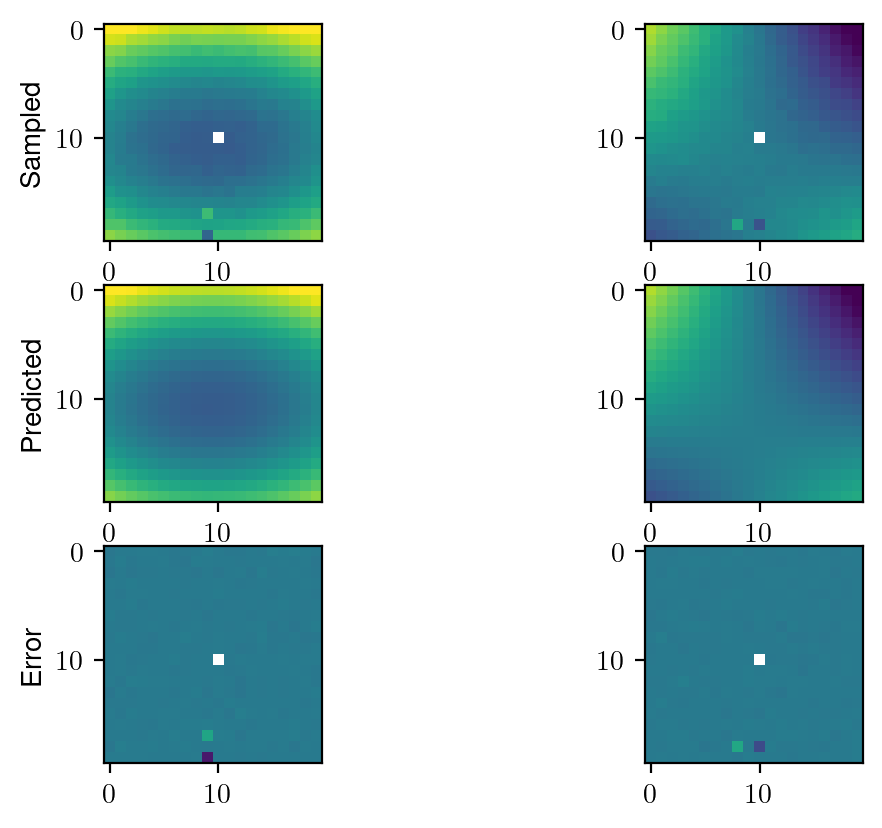

In [45]:
vmax = torch.nan_to_num(sampled_gradient).max()*.9
vmin = torch.nan_to_num(sampled_gradient).min()*.9

fig,ax = plt.subplots(3,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0],vmax=vmax, vmin=vmin); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1],vmax=vmax, vmin=vmin)
ax[1,0].imshow(derivs_pred[0],vmax=vmax, vmin=vmin); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(derivs_pred[1],vmax=vmax, vmin=vmin)
ax[2,0].imshow(sampled_gradient[0]-derivs_pred[0],vmax=vmax, vmin=vmin); ax[2,0].set_ylabel('Error')
ax[2,1].imshow(sampled_gradient[1]-derivs_pred[1],vmax=vmax, vmin=vmin)

Text(0.5, 1.0, 'Error')

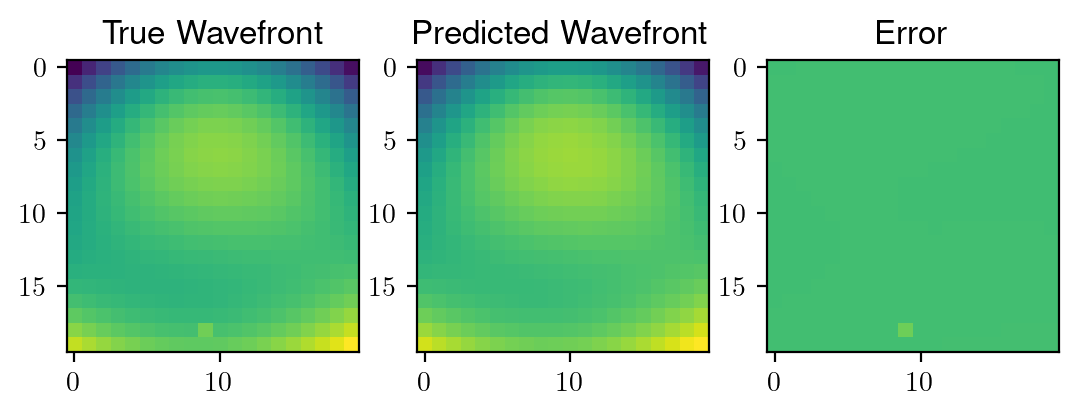

In [46]:
vmax = wavefront.max()
vmin = wavefront.min()

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(wavefront,vmax=vmax,vmin=vmin); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_pred,vmax=vmax,vmin=vmin); ax[1].set_title('Predicted Wavefront')
ax[2].imshow(wavefront-wavefront_pred,vmax=vmax,vmin=vmin); ax[2].set_title('Error')

#(wavefront_pred/wavefront).mean(), (wavefront_pred/wavefront).std()

In [47]:
evaller.aff_model.rot_list, evaller.aff_model.transX_list, evaller.aff_model.transY_list

(Parameter containing:
 tensor([ 0.0000, -1.0803], device='cuda:3', requires_grad=True),
 Parameter containing:
 tensor([0.0000, 0.0951], device='cuda:3', requires_grad=True),
 Parameter containing:
 tensor([ 0.0000, -0.0146], device='cuda:3', requires_grad=True))

In [48]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)